# Linear Regression with Pytorch and D2L 

## First Step: Generation of synthetic data

In [19]:
from d2l import torch as d2l

class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w: d2l.torch.Tensor, b: d2l.torch.Tensor, noise=0.01, n_train=1000, n_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n_total = n_train + n_val
        self.n = n_total
        self.X = d2l.randn(n_total, len(w))

        noise_vector = d2l.randn(n_total)

        self.y = d2l.matmul(self.X, w) + b + (noise_vector * noise)
    
    def __str__(self):
        res = ""

        for i in range(len(self.X)):
            res += str(self.X[i][0]) + ", " + str(self.X[i][1]) + ": " +  str(self.y[i]) + "\n"

        return res

In [20]:
import random

# Naive Implementation
# Although good for thinking about how data must be passed for training and validation processes, this implementation is bad for real training
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.n_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.n_train, self.n))
    
    for index in range(0, len(indices), self.batch_size):
        batch_indices = indices[index:(index+self.batch_size)]
        yield self.X[batch_indices], self.y[batch_indices]

In [21]:
# Enhanced Implementation
# Uses internal optimization for handling multiprocessing and processing small amounts of data at each iteraction
@d2l.add_to_class(SyntheticRegressionData)
def get_tensorloader(self, tensors, indices, train, batch_size):
    tensors = tuple(t[indices] for t in tensors)
    dataset = d2l.torch.utils.data.TensorDataset(*tensors)
    return d2l.torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData) #@save
def get_dataloader(self, train): 
    indices = slice(0, self.n_train) if train else slice(self.n_train, self.n)
    return self.get_tensorloader([self.X, self.y], indices, train, self.batch_size)


## Second Step: defining the model

In [22]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        #self.w = d2l.torch.normal(0.0, sigma, (num_inputs,), requires_grad=True)
        self.w = d2l.torch.zeros((num_inputs,) , requires_grad=True)
        #self.b = d2l.torch.normal(0.0, sigma, (1,), requires_grad=True)
        self.b = d2l.torch.zeros((1,), requires_grad=True)

    def forward(self, X):
        return d2l.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        sqr_diff = (y - y_hat) ** 2
        return sqr_diff.mean()

# Stochastic Gradient Descent: defining model's optimizers
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= param.grad * self.lr
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

test = LinearRegressionScratch(3, 0.01)
test.w, test.b

(tensor([0., 0., 0.], requires_grad=True), tensor([0.], requires_grad=True))

## Step 3: `fit_epoch`, the training method

In [23]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        self.optim.zero_grad()
        loss = self.model.training_step(self.prepare_batch(batch))

        with d2l.torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()

        self.train_batch_idx += 1

    for batch in self.val_dataloader:
        with d2l.torch.no_grad():
            self.model.validation_step(batch)
        
        self.val_batch_idx += 1
            





# Step 4: Training

(tensor([ 1.9982e+00, -3.4027e+00,  5.9983e+00,  1.2003e+01,  1.4240e+03,
          1.0026e+00], requires_grad=True),
 tensor([4.1977], requires_grad=True))

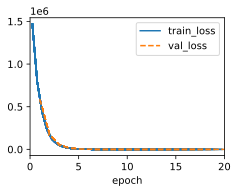

In [24]:
model = LinearRegressionScratch(6, lr=0.01)
data = SyntheticRegressionData(w=d2l.torch.tensor([2, -3.4, 6, 12, 1424, 1]), b=4.2)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

trainer.model.w, trainer.model.b